In [1]:
#import required libraries

import pandas as pd
import yfinance as yf
import numpy as np
import math
import pandas_ta as ta

In [2]:
# parameter setup (default values in the original indicator)
length = 20
mult = 2
length_KC = 21
mult_KC = 1.5

In [3]:
stock = yf.Ticker("AAPL")
print(stock.info)

{'zip': '95014', 'sector': 'Technology', 'fullTimeEmployees': 100000, 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, iPod touch, and other Apple-branded and third-party accessories. It also provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store, that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand radi

In [4]:
stock_df = stock.history(period="1y", interval='1d')
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-07-29,93.122526,94.592623,93.085278,94.403893,90329200,0.0,0.0
2020-07-30,93.557104,95.652982,93.139917,95.546204,158130000,0.0,0.0
2020-07-31,102.196394,105.702767,100.150176,105.548805,374336800,0.0,0.0
2020-08-03,107.475822,110.890315,107.170385,108.208389,308151200,0.0,0.0
2020-08-04,108.402078,110.048485,107.662061,108.931015,173071600,0.0,0.0
...,...,...,...,...,...,...,...
2021-07-22,145.940002,148.199997,145.809998,146.800003,77338200,0.0,0.0
2021-07-23,147.550003,148.720001,146.919998,148.559998,71361600,0.0,0.0
2021-07-26,148.270004,149.830002,147.699997,148.990005,72269700,0.0,0.0


In [5]:
# calculate Bollinger Bands
# moving average
m_avg = df_stock['Close'].rolling(window=length).mean()
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std(ddof=0)
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std

In [6]:
# calculate Keltner Channel
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma = df_stock['tr'].rolling(window=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

In [7]:
# check for 'squeeze'
df_stock['squeeze_on'] = (df_stock['lower_BB'] > df_stock['lower_KC']) & (df_stock['upper_BB'] < df_stock['upper_KC'])
df_stock['squeeze_off'] = (df_stock['lower_BB'] < df_stock['lower_KC']) & (df_stock['upper_BB'] > df_stock['upper_KC'])

In [8]:
# Momentum
highest = df_stock['High'].rolling(window = length_KC).max()
lowest = df_stock['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df_stock['value'] = (df_stock['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df_stock['value'] = df_stock['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y, x, 1)[1], raw=True)

df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,upper_BB,lower_BB,tr0,tr1,tr2,tr,upper_KC,lower_KC,squeeze_on,squeeze_off,value
Date,,,,,,,,,,,,,,,,,,
2020-07-29,93.122526,94.592623,93.085278,94.403893,90329200,0.0,0.0,NaN,NaN,1.507345,NaN,NaN,1.507345,NaN,NaN,False,False,NaN
2020-07-30,93.557104,95.652982,93.139917,95.546204,158130000,0.0,0.0,NaN,NaN,2.513066,1.249090,1.263976,2.513066,NaN,NaN,False,False,NaN
2020-07-31,102.196394,105.702767,100.150176,105.548805,374336800,0.0,0.0,NaN,NaN,5.552590,10.156563,4.603973,10.156563,NaN,NaN,False,False,NaN
2020-08-03,107.475822,110.890315,107.170385,108.208389,308151200,0.0,0.0,NaN,NaN,3.719930,5.341510,1.621580,5.341510,NaN,NaN,False,False,NaN
2020-08-04,108.402078,110.048485,107.662061,108.931015,173071600,0.0,0.0,NaN,NaN,2.386424,1.840096,0.546328,2.386424,NaN,NaN,False,False,NaN


In [9]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df_stock['squeeze_off'][-2] == False) | (df_stock['squeeze_off'][-1] == True) 
# 2. bar value is positive => the bar is light green
long_cond2 = df_stock['value'][-1] > 0

enter_long = long_cond1 and long_cond2
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df_stock['squeeze_off'][-2] == False) | (df_stock['squeeze_off'][-1] == True) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df_stock['value'][-1] < 0
enter_short = short_cond1 and short_cond2

In [10]:
import mplfinance as mpf
%matplotlib widget

In [11]:
ohcl = df_stock[['Open', 'High', 'Close', 'Low']]
ohcl.head()

,Open,High,Close,Low
Date,,,,
2020-07-29,93.122526,94.592623,94.403893,93.085278
2020-07-30,93.557104,95.652982,95.546204,93.139917
2020-07-31,102.196394,105.702767,105.548805,100.150176
2020-08-03,107.475822,110.890315,108.208389,107.170385
2020-08-04,108.402078,110.048485,108.931015,107.662061


In [12]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock['value']):
  if val >= 0:
    color = 'green'
    if val > df_stock['value'][ind-1]:
      color = 'lime'
  else:
    color = 'maroon'
    if val < df_stock['value'][ind-1]:
      color='red'
  colors.append(color)

In [13]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='x', markersize=50, color=['gray' if s else 'black' for s in df_stock['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock[['lower_KC']], color = 'blue')]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              mav = (8,21,34),
              type='candle', 
              addplot=apds,
              returnfig=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
screened_list = []
stock_list = ['AAPL','TSLA','MSFT','AMZN']

for stock_code in stock_list:
    df = yf.download(stock_code, start='2020-01-01', threads= False)
    if enter_long | enter_short:
        screened_list.append(stock_code)
    
if screened_list:
  print(screened_list)
else:
  print('No stock fits the indicator entry requirement')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
['AAPL', 'TSLA', 'MSFT', 'AMZN']


In [15]:
help(mpf.plot)

Help on function plot in module mplfinance.plotting:

plot(data, **kwargs)
    Given a Pandas DataFrame containing columns Open,High,Low,Close and optionally Volume
    with a DatetimeIndex, plot the data.
    Available plots include ohlc bars, candlestick, and line plots.
    Also provide visually analysis in the form of common technical studies, such as:
    moving averages, renko, etc.
    Also provide ability to plot trading signals, and/or addtional user-defined data.



In [16]:
tickers = ['NFLX', 'AAPL', 'FB', 'GOOG', 'AMZN']

ticker_dict_1mo = {}
ticker_dict_1wk = {}
ticker_dict_1d = {}
for stock in tickers:
    ticker_dict_1mo[stock] = yf.Ticker(stock).history(period="10y", interval='1mo')
    ticker_dict_1mo[stock]["ticker"] = stock
    ticker_dict_1wk[stock] = yf.Ticker(stock).history(period="10y", interval='1wk')
    ticker_dict_1wk[stock]['ticker'] = stock
    ticker_dict_1d[stock] = yf.Ticker(stock).history(period="10y", interval='1d')
    ticker_dict_1d[stock]['ticker'] = stock
    
ticker_dict_1mo['AAPL']

monthly_data = pd.concat(ticker_dict_1mo.values())
monthly_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2011-08-01,38.362858,38.500000,29.049999,33.572857,6.405847e+08,0.0,0.0,NFLX
2011-09-01,33.504288,34.071430,15.375714,16.181429,1.679588e+09,0.0,0.0,NFLX
2011-10-01,16.448570,18.357143,10.607143,11.725714,1.691083e+09,0.0,0.0,NFLX
2011-11-01,11.444286,13.405714,8.910000,9.218571,1.053462e+09,0.0,0.0,NFLX
2011-12-01,9.202857,11.084286,9.142857,9.898571,8.420356e+08,0.0,0.0,NFLX
...,...,...,...,...,...,...,...,...
2021-04-01,3117.939941,3554.000000,3115.550049,3467.419922,7.683960e+07,0.0,0.0,AMZN
2021-05-01,3484.729980,3486.649902,3127.370117,3223.070068,7.518390e+07,0.0,0.0,AMZN
2021-06-01,3243.500000,3524.860107,3172.199951,3440.159912,6.701100e+07,0.0,0.0,AMZN


In [17]:
# calculate Bollinger Bands
m_avg_mo = {}
m_avg_wk = {}
m_avg_d = {}
m_std_mo = {}
m_std_wk = {}
m_std_d = {}

for stock in tickers:
    # moving average
    m_avg_mo[stock] = ticker_dict_1mo[stock]['Close'].rolling(window=length).mean()
    m_avg_wk[stock] = ticker_dict_1wk[stock]['Close'].rolling(window=length).mean()
    m_avg_d[stock] = ticker_dict_1d[stock]['Close'].rolling(window=length).mean()
    # standard deviation
    m_std_mo[stock] = ticker_dict_1mo[stock]['Close'].rolling(window=length).std(ddof=0)
    m_std_wk[stock] = ticker_dict_1wk[stock]['Close'].rolling(window=length).std(ddof=0)
    m_std_d[stock] = ticker_dict_1d[stock]['Close'].rolling(window=length).std(ddof=0)
    # upper Bollinger Bands
    ticker_dict_1mo[stock]['upper_BB'] = m_avg_mo[stock] + mult * m_std_mo[stock]
    ticker_dict_1wk[stock]['upper_BB'] = m_avg_wk[stock] + mult * m_std_wk[stock]
    ticker_dict_1d[stock]['upper_BB'] = m_avg_d[stock] + mult * m_std_d[stock]
# lower Bollinger Bands 
    ticker_dict_1mo[stock]['lower_BB'] = m_avg_mo[stock] - mult * m_std_mo[stock]
    ticker_dict_1wk[stock]['lower_BB'] = m_avg_wk[stock] - mult * m_std_wk[stock]
    ticker_dict_1d[stock]['lower_BB'] = m_avg_d[stock] - mult * m_std_d[stock]
    
ticker_dict_1d[stock]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,upper_BB,lower_BB
Date,,,,,,,,,,
2011-07-29,221.289993,225.750000,219.509995,222.520004,5167700,0,0,AMZN,NaN,NaN
2011-08-01,225.000000,227.449997,217.660004,221.320007,5789300,0,0,AMZN,NaN,NaN
2011-08-02,220.320007,222.429993,211.300003,211.699997,6586700,0,0,AMZN,NaN,NaN
2011-08-03,212.970001,214.830002,205.539993,209.960007,8197100,0,0,AMZN,NaN,NaN
2011-08-04,206.729996,208.000000,201.449997,201.479996,6579500,0,0,AMZN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3265400,0,0,AMZN,3798.900771,3358.917198
2021-07-23,3640.000000,3666.110107,3622.040039,3656.639893,2430700,0,0,AMZN,3803.303062,3375.270889
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,2896300,0,0,AMZN,3804.954609,3403.455352


In [18]:
# calculate Keltner Channel
range_ma_mo = {}
range_ma_wk = {}
range_ma_d = {}

for stock in tickers:
    # first we need to calculate True Range (monthly)
    ticker_dict_1mo[stock]['tr0'] = abs(ticker_dict_1mo[stock]["High"] - ticker_dict_1mo[stock]["Low"])
    ticker_dict_1mo[stock]['tr1'] = abs(ticker_dict_1mo[stock]["High"] - ticker_dict_1mo[stock]["Close"].shift())
    ticker_dict_1mo[stock]['tr2'] = abs(ticker_dict_1mo[stock]["Low"] - ticker_dict_1mo[stock]["Close"].shift())
    ticker_dict_1mo[stock]['tr'] = ticker_dict_1mo[stock][['tr0', 'tr1', 'tr2']].max(axis=1)
    
    # first we need to calculate True Range (weekly)
    ticker_dict_1wk[stock]['tr0'] = abs(ticker_dict_1wk[stock]["High"] - ticker_dict_1wk[stock]["Low"])
    ticker_dict_1wk[stock]['tr1'] = abs(ticker_dict_1wk[stock]["High"] - ticker_dict_1wk[stock]["Close"].shift())
    ticker_dict_1wk[stock]['tr2'] = abs(ticker_dict_1wk[stock]["Low"] - ticker_dict_1wk[stock]["Close"].shift())
    ticker_dict_1wk[stock]['tr'] = ticker_dict_1wk[stock][['tr0', 'tr1', 'tr2']].max(axis=1)
    
    # first we need to calculate True Range (daily)
    ticker_dict_1d[stock]['tr0'] = abs(ticker_dict_1d[stock]["High"] - ticker_dict_1d[stock]["Low"])
    ticker_dict_1d[stock]['tr1'] = abs(ticker_dict_1d[stock]["High"] - ticker_dict_1d[stock]["Close"].shift())
    ticker_dict_1d[stock]['tr2'] = abs(ticker_dict_1d[stock]["Low"] - ticker_dict_1d[stock]["Close"].shift())
    ticker_dict_1d[stock]['tr'] = ticker_dict_1d[stock][['tr0', 'tr1', 'tr2']].max(axis=1)

    # moving average of the TR
    range_ma_mo[stock] = ticker_dict_1mo[stock]['tr'].rolling(window=length_KC).mean()
    range_ma_wk[stock] = ticker_dict_1wk[stock]['tr'].rolling(window=length_KC).mean()
    range_ma_d[stock] = ticker_dict_1d[stock]['tr'].rolling(window=length_KC).mean()
    
    # upper Keltner Channel
    ticker_dict_1mo[stock]['upper_KC'] = m_avg_mo[stock] + range_ma_mo[stock] * mult_KC
    ticker_dict_1wk[stock]['upper_KC'] = m_avg_wk[stock] + range_ma_wk[stock] * mult_KC
    ticker_dict_1d[stock]['upper_KC'] = m_avg_d[stock] + range_ma_d[stock] * mult_KC
    
    # lower Keltner Channel
    ticker_dict_1mo[stock]['lower_KC'] = m_avg_mo[stock] - range_ma_mo[stock] * mult_KC
    ticker_dict_1wk[stock]['lower_KC'] = m_avg_wk[stock] - range_ma_wk[stock] * mult_KC
    ticker_dict_1d[stock]['lower_KC'] = m_avg_d[stock] - range_ma_d[stock] * mult_KC

ticker_dict_1d[stock]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,upper_BB,lower_BB,tr0,tr1,tr2,tr,upper_KC,lower_KC
Date,,,,,,,,,,,,,,,,
2011-07-29,221.289993,225.750000,219.509995,222.520004,5167700,0,0,AMZN,NaN,NaN,6.240005,NaN,NaN,6.240005,NaN,NaN
2011-08-01,225.000000,227.449997,217.660004,221.320007,5789300,0,0,AMZN,NaN,NaN,9.789993,4.929993,4.860001,9.789993,NaN,NaN
2011-08-02,220.320007,222.429993,211.300003,211.699997,6586700,0,0,AMZN,NaN,NaN,11.129990,1.109985,10.020004,11.129990,NaN,NaN
2011-08-03,212.970001,214.830002,205.539993,209.960007,8197100,0,0,AMZN,NaN,NaN,9.290009,3.130005,6.160004,9.290009,NaN,NaN
2011-08-04,206.729996,208.000000,201.449997,201.479996,6579500,0,0,AMZN,NaN,NaN,6.550003,1.960007,8.510010,8.510010,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3265400,0,0,AMZN,3798.900771,3358.917198,57.750000,54.820068,2.929932,57.750000,3685.305434,3472.512535
2021-07-23,3640.000000,3666.110107,3622.040039,3656.639893,2430700,0,0,AMZN,3803.303062,3375.270889,44.070068,28.080078,15.989990,44.070068,3696.131283,3482.442667
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,2896300,0,0,AMZN,3804.954609,3403.455352,64.830078,55.440186,9.389893,64.830078,3708.965008,3499.444953


In [19]:
# check for 'squeeze'
for stock in tickers:
    #monthly
    ticker_dict_1mo[stock]['squeeze_on'] = (ticker_dict_1mo[stock]['lower_BB'] > ticker_dict_1mo[stock]['lower_KC']) | (ticker_dict_1mo[stock]['upper_BB'] < ticker_dict_1mo[stock]['upper_KC'])
    ticker_dict_1mo[stock]['squeeze_off'] = (ticker_dict_1mo[stock]['lower_BB'] < ticker_dict_1mo[stock]['lower_KC']) | (ticker_dict_1mo[stock]['upper_BB'] > ticker_dict_1mo[stock]['upper_KC'])
    
    #weekly
    ticker_dict_1wk[stock]['squeeze_on'] = (ticker_dict_1wk[stock]['lower_BB'] > ticker_dict_1wk[stock]['lower_KC']) | (ticker_dict_1wk[stock]['upper_BB'] < ticker_dict_1wk[stock]['upper_KC'])
    ticker_dict_1wk[stock]['squeeze_off'] = (ticker_dict_1wk[stock]['lower_BB'] < ticker_dict_1wk[stock]['lower_KC']) | (ticker_dict_1wk[stock]['upper_BB'] > ticker_dict_1wk[stock]['upper_KC'])
    
    #daily
    ticker_dict_1d[stock]['squeeze_on'] = (ticker_dict_1d[stock]['lower_BB'] > ticker_dict_1d[stock]['lower_KC']) | (ticker_dict_1d[stock]['upper_BB'] < ticker_dict_1d[stock]['upper_KC'])
    ticker_dict_1d[stock]['squeeze_off'] = (ticker_dict_1d[stock]['lower_BB'] < ticker_dict_1d[stock]['lower_KC']) | (ticker_dict_1d[stock]['upper_BB'] > ticker_dict_1d[stock]['upper_KC'])
    
ticker_dict_1d[stock]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,upper_BB,lower_BB,tr0,tr1,tr2,tr,upper_KC,lower_KC,squeeze_on,squeeze_off
Date,,,,,,,,,,,,,,,,,,
2011-07-29,221.289993,225.750000,219.509995,222.520004,5167700,0,0,AMZN,NaN,NaN,6.240005,NaN,NaN,6.240005,NaN,NaN,False,False
2011-08-01,225.000000,227.449997,217.660004,221.320007,5789300,0,0,AMZN,NaN,NaN,9.789993,4.929993,4.860001,9.789993,NaN,NaN,False,False
2011-08-02,220.320007,222.429993,211.300003,211.699997,6586700,0,0,AMZN,NaN,NaN,11.129990,1.109985,10.020004,11.129990,NaN,NaN,False,False
2011-08-03,212.970001,214.830002,205.539993,209.960007,8197100,0,0,AMZN,NaN,NaN,9.290009,3.130005,6.160004,9.290009,NaN,NaN,False,False
2011-08-04,206.729996,208.000000,201.449997,201.479996,6579500,0,0,AMZN,NaN,NaN,6.550003,1.960007,8.510010,8.510010,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3265400,0,0,AMZN,3798.900771,3358.917198,57.750000,54.820068,2.929932,57.750000,3685.305434,3472.512535,False,True
2021-07-23,3640.000000,3666.110107,3622.040039,3656.639893,2430700,0,0,AMZN,3803.303062,3375.270889,44.070068,28.080078,15.989990,44.070068,3696.131283,3482.442667,False,True
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,2896300,0,0,AMZN,3804.954609,3403.455352,64.830078,55.440186,9.389893,64.830078,3708.965008,3499.444953,False,True


In [20]:
# Momentum
highest_mo = {}
highest_wk = {}
highest_d = {}
lowest_mo = {}
lowest_wk = {}
lowest_d = {}
m1_mo = {}
m1_wk = {}
m1_d = {}
fit_y_mo = {}
fit_y_wk = {}
fit_y_d = {}


for stock in tickers:
    #monthly
    highest_mo[stock] = ticker_dict_1mo[stock]['High'].rolling(window = length_KC).max()
    lowest_mo[stock] = ticker_dict_1mo[stock]['Low'].rolling(window = length_KC).min()
    m1_mo[stock] = (highest_mo[stock] + lowest_mo[stock]) / 2
    ticker_dict_1mo[stock]['value'] = (ticker_dict_1mo[stock]['Close'] - (m1_mo[stock] + m_avg_mo[stock])/2)
    fit_y_mo[stock] = np.array(range(0,length_KC))
    ticker_dict_1mo[stock]['value'] = ticker_dict_1mo[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_mo[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_mo[stock], x, 1)[1], raw=True)
    
    #weekly
    highest_wk[stock] = ticker_dict_1wk[stock]['High'].rolling(window = length_KC).max()
    lowest_wk[stock] = ticker_dict_1wk[stock]['Low'].rolling(window = length_KC).min()
    m1_wk[stock] = (highest_wk[stock] + lowest_wk[stock]) / 2
    ticker_dict_1wk[stock]['value'] = (ticker_dict_1wk[stock]['Close'] - (m1_wk[stock] + m_avg_wk[stock])/2)
    fit_y_wk[stock] = np.array(range(0,length_KC))
    ticker_dict_1wk[stock]['value'] = ticker_dict_1wk[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_wk[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_wk[stock], x, 1)[1], raw=True)
    
    #daily
    highest_d[stock] = ticker_dict_1d[stock]['High'].rolling(window = length_KC).max()
    lowest_d[stock] = ticker_dict_1d[stock]['Low'].rolling(window = length_KC).min()
    m1_d[stock] = (highest_d[stock] + lowest_d[stock]) / 2
    ticker_dict_1d[stock]['value'] = (ticker_dict_1d[stock]['Close'] - (m1_d[stock] + m_avg_d[stock])/2)
    fit_y_d[stock] = np.array(range(0,length_KC))
    ticker_dict_1d[stock]['value'] = ticker_dict_1d[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_d[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_d[stock], x, 1)[1], raw=True)
    
ticker_dict_1d[stock]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,upper_BB,lower_BB,tr0,tr1,tr2,tr,upper_KC,lower_KC,squeeze_on,squeeze_off,value
Date,,,,,,,,,,,,,,,,,,,
2011-07-29,221.289993,225.750000,219.509995,222.520004,5167700,0,0,AMZN,NaN,NaN,6.240005,NaN,NaN,6.240005,NaN,NaN,False,False,NaN
2011-08-01,225.000000,227.449997,217.660004,221.320007,5789300,0,0,AMZN,NaN,NaN,9.789993,4.929993,4.860001,9.789993,NaN,NaN,False,False,NaN
2011-08-02,220.320007,222.429993,211.300003,211.699997,6586700,0,0,AMZN,NaN,NaN,11.129990,1.109985,10.020004,11.129990,NaN,NaN,False,False,NaN
2011-08-03,212.970001,214.830002,205.539993,209.960007,8197100,0,0,AMZN,NaN,NaN,9.290009,3.130005,6.160004,9.290009,NaN,NaN,False,False,NaN
2011-08-04,206.729996,208.000000,201.449997,201.479996,6579500,0,0,AMZN,NaN,NaN,6.550003,1.960007,8.510010,8.510010,NaN,NaN,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-22,3587.229980,3640.020020,3582.270020,3638.030029,3265400,0,0,AMZN,3798.900771,3358.917198,57.750000,54.820068,2.929932,57.750000,3685.305434,3472.512535,False,True,60.570962
2021-07-23,3640.000000,3666.110107,3622.040039,3656.639893,2430700,0,0,AMZN,3803.303062,3375.270889,44.070068,28.080078,15.989990,44.070068,3696.131283,3482.442667,False,True,59.443837
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,2896300,0,0,AMZN,3804.954609,3403.455352,64.830078,55.440186,9.389893,64.830078,3708.965008,3499.444953,False,True,60.200717


In [21]:
long_cond1_mo = {}
long_cond2_mo = {}
enter_long_mo = {}
short_cond1_mo = {}
short_cond2_mo = {}
enter_short_mo = {}
long_cond1_wk = {}
long_cond2_wk = {}
enter_long_wk = {}
short_cond1_wk = {}
short_cond2_wk = {}
enter_short_wk = {}
long_cond1_d = {}
long_cond2_d = {}
enter_long_d = {}
short_cond1_d = {}
short_cond2_d = {}
enter_short_d = {}

for stock in tickers:
    #monthly
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_mo[stock] = (ticker_dict_1mo[stock]['squeeze_off'][-2] == False) | (ticker_dict_1mo[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_mo[stock] = ticker_dict_1mo[stock]['value'][-1] > 0

    enter_long_mo[stock] = long_cond1_mo[stock] and long_cond2_mo[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_mo[stock] = (ticker_dict_1mo[stock]['squeeze_off'][-2] == False) | (ticker_dict_1mo[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_mo[stock] = ticker_dict_1mo[stock]['value'][-1] < 0
    enter_short_mo[stock] = short_cond1_mo[stock] and short_cond2_mo[stock]
    
    #weekly
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_wk[stock] = (ticker_dict_1wk[stock]['squeeze_off'][-2] == False) | (ticker_dict_1wk[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_wk[stock] = ticker_dict_1wk[stock]['value'][-1] > 0

    enter_long_wk[stock] = long_cond1_wk[stock] and long_cond2_wk[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_wk[stock] = (ticker_dict_1wk[stock]['squeeze_off'][-2] == False) | (ticker_dict_1wk[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_wk[stock] = ticker_dict_1wk[stock]['value'][-1] < 0
    enter_short_wk[stock] = short_cond1_wk[stock] and short_cond2_wk[stock]
    
    #daily
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_d[stock] = (ticker_dict_1d[stock]['squeeze_off'][-2] == False) | (ticker_dict_1d[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_d[stock] = ticker_dict_1d[stock]['value'][-1] > 0

    enter_long_d[stock] = long_cond1_d[stock] and long_cond2_d[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_d[stock] = (ticker_dict_1d[stock]['squeeze_off'][-2] == False) | (ticker_dict_1d[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_d[stock] = ticker_dict_1d[stock]['value'][-1] < 0
    enter_short_d[stock] = short_cond1_d[stock] and short_cond2_d[stock]

In [22]:
ohcl_mo = {}
ohcl_wk = {}
ohcl_d = {}

for stock in tickers:
    ohcl_mo[stock] = ticker_dict_1mo[stock][['Open', 'High', 'Close', 'Low']]
    ohcl_wk[stock] = ticker_dict_1wk[stock][['Open', 'High', 'Close', 'Low']]
    ohcl_d[stock] = ticker_dict_1d[stock][['Open', 'High', 'Close', 'Low']]
    
ohcl_d[stock]

,Open,High,Close,Low
Date,,,,
2011-07-29,221.289993,225.750000,222.520004,219.509995
2011-08-01,225.000000,227.449997,221.320007,217.660004
2011-08-02,220.320007,222.429993,211.699997,211.300003
2011-08-03,212.970001,214.830002,209.960007,205.539993
2011-08-04,206.729996,208.000000,201.479996,201.449997
...,...,...,...,...
2021-07-22,3587.229980,3640.020020,3638.030029,3582.270020
2021-07-23,3640.000000,3666.110107,3656.639893,3622.040039
2021-07-26,3673.169922,3712.080078,3699.820068,3647.250000


In [23]:
ind_mo = {}
val_mo = {}
ind_wk = {}
val_wk = {}
ind_d = {}
val_d = {}

for stock in tickers:
    # add colors for the 'value bar'
    colors_mo = []
    for ind_mo[stock], val_mo[stock] in enumerate(ticker_dict_1mo[stock]['value']):
        if val_mo[stock] >= 0:
            color_mo = 'green'
        if val_mo[stock] > ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
            color_mo = 'lime'
        else:
            color_mo = 'maroon'
        if val_mo[stock] < ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
            color_mo='red'
        colors_mo.append(color)
        
    #colors_mo = []
    #for ind_mo[stock], val_mo[stock] in enumerate(ticker_dict_1mo[stock]['value']):
       # if val_mo[stock] >= 0:
            #color_mo = 'green'
        #if val_mo[stock] > ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
           # color_mo = 'lime'
       # else:
            #color_mo = 'maroon'
        #if val_mo[stock] < ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
           # color_mo='red'
      #  colors_mo.append(color)
        
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Column
    [0] Column
        [0] Select(name='stock', options=['NFLX', 'AAPL', ...], value='NFLX')
    [1] Row
        [0] Matplotlib(Figure, tight=True)
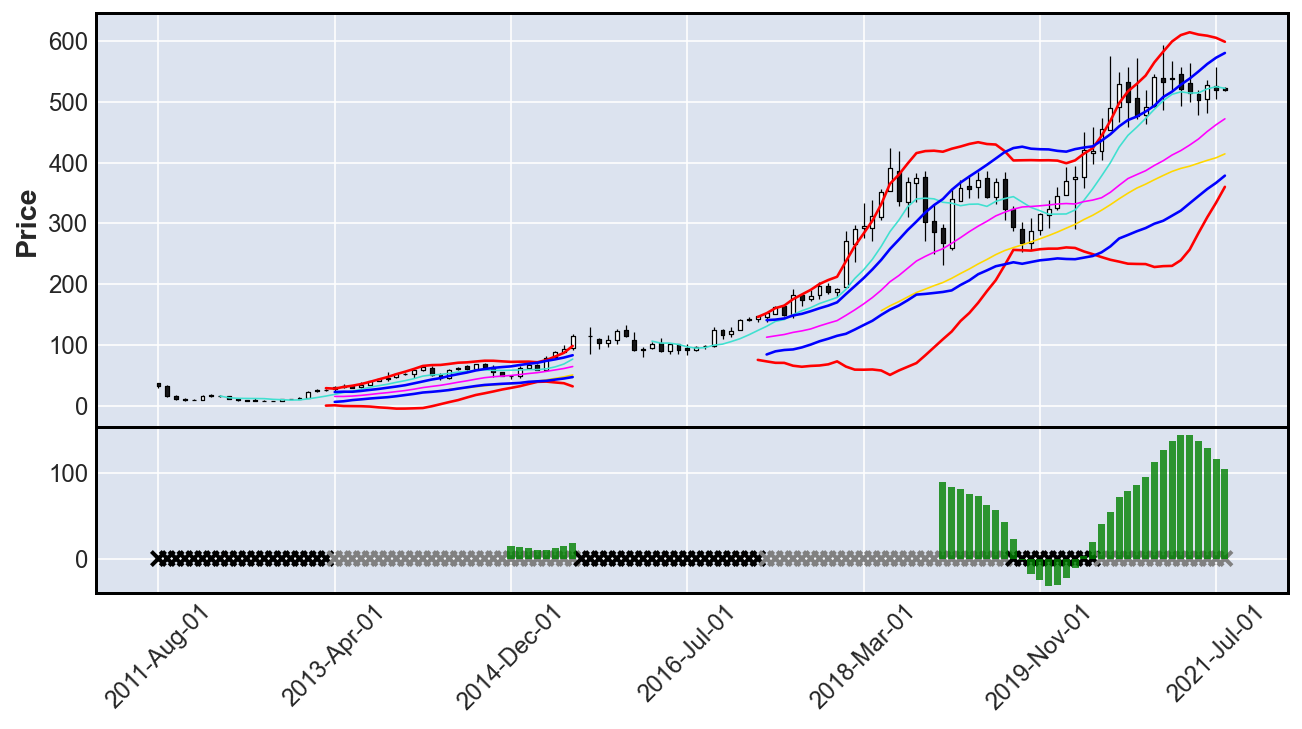

In [26]:
import panel as pn
from panel.interact import interact

pn.extension()

def figure_stock_mo(stock):
    apds = [mpf.make_addplot(ticker_dict_1mo[stock]['value'], panel=1, type='bar', color=colors_mo, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(ticker_dict_1mo[stock]), panel=1, type='scatter', marker='x', markersize=50, color=['gray' if s else 'black' for s in ticker_dict_1mo[stock]['squeeze_off']], secondary_y=False),
            mpf.make_addplot(ticker_dict_1mo[stock][['upper_BB']], color = 'red'),
            mpf.make_addplot(ticker_dict_1mo[stock][['lower_BB']], color = 'red'),
            mpf.make_addplot(ticker_dict_1mo[stock][['upper_KC']], color = 'blue'),
            mpf.make_addplot(ticker_dict_1mo[stock][['lower_KC']], color = 'blue')]

    # plot ohcl with subplots
    fig, axes = mpf.plot(ohcl_mo[stock], 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              mav = (8,21,34),
              type='candle', 
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

ticker = monthly_data["ticker"].unique()
interact(figure_stock_mo, stock=ticker)